Wilcoxon signed-rank tests (paired Seq2Seq vs. CMR for each split):
    90-5-5: two-sided W=8.00, p=4.77e-05 | less W=8.00, p=2.38e-05 | greater W=8.00, p=1 | r_rb=-0.924
  60-20-20: two-sided W=0.00, p=1.91e-06 | less W=210.00, p=1 | greater W=210.00, p=9.54e-07 | r_rb=1.000
  40-30-30: two-sided W=5.00, p=1.91e-05 | less W=205.00, p=1 | greater W=205.00, p=9.54e-06 | r_rb=0.952


/tmp/ipykernel_137009/2405048895.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(df_bar['Participant'].unique(), rotation=45, ha='right', fontsize=18)


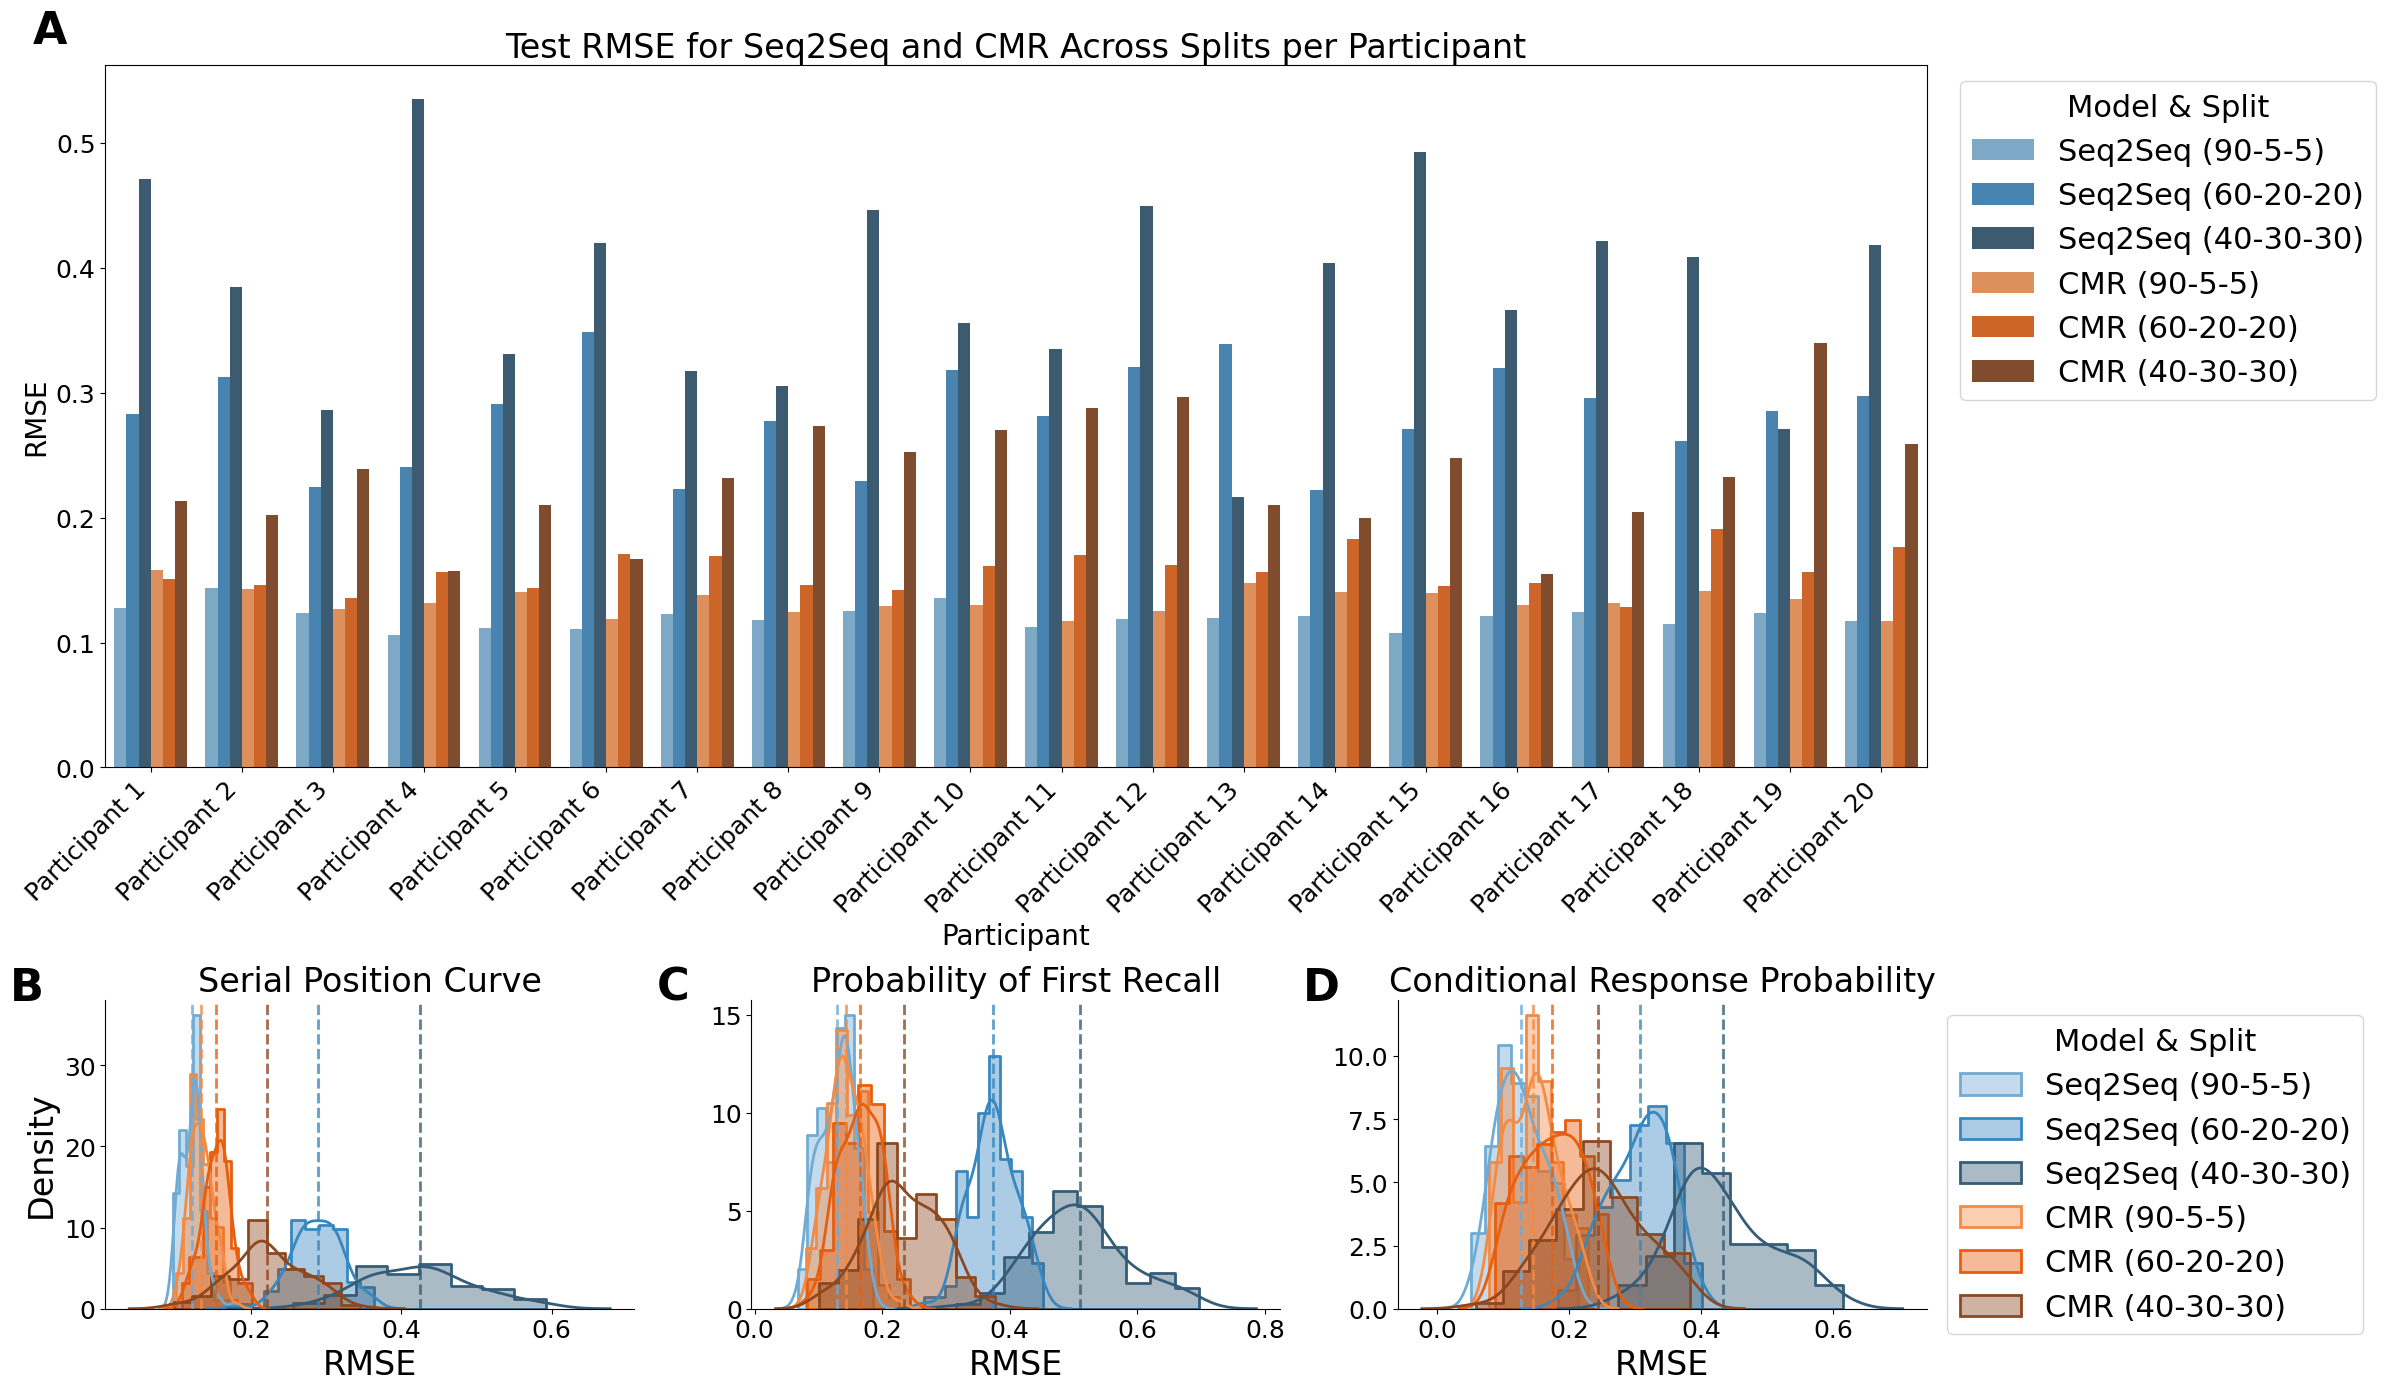

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata
import pickle
import os

def rank_biserial_from_pairs(x, y):
    d = np.asarray(x) - np.asarray(y)
    d = d[d != 0]
    if d.size == 0:
        return np.nan
    rks = rankdata(np.abs(d), method='average')
    return (rks[d > 0].sum() - rks[d < 0].sum()) / rks.sum()

np.random.seed(42)

datafile = "datasplit_rmses.pkl"
n_subjects = 20
split_sizes = ["90-5-5", "60-20-20", "40-30-30"]
subplot_labels = ['A', 'B', 'C', 'D']  # Adjust length if you add/remove subplots
models = ["Seq2Seq", "CMR"]
bars = [(m, s) for m in models for s in split_sizes]  # 6 combos

with open(datafile, "rb") as f:
    df_bar = pickle.load(f)
    hist_dict = pickle.load(f)

### Convert Subject references to participant
df_bar = df_bar.rename(columns={"Subject": "Participant"})
df_bar["Participant"] = df_bar["Participant"].astype(str)
def convert_subject_to_participant(s):
    if isinstance(s, str) and s.startswith("Subject "):
        return s.replace("Subject ", "Participant ")
    return s

df_bar["Participant"] = df_bar["Participant"].apply(convert_subject_to_participant)

hist_data = [
    {
        "title": "Serial Position Curve",
        "rmse_dict": {k: v for k, v in hist_dict.items()}
    },
    {
        "title": "Probability of First Recall",
        "rmse_dict": {k: [x + np.random.uniform(-0.03, 0.05) for x in v] if 'CMR' in k or '90' in k else [x + np.random.uniform(0.05, 0.12) for x in v] for k, v in hist_dict.items()}
    },
    {
        "title": "Conditional Response Probability",
        "rmse_dict": {k: [x + np.random.uniform(-0.05, 0.08) for x in v] if 'CMR' or '90' in k in k else [x + np.random.uniform(-0.05, 0.08) for x in v] for k, v in hist_dict.items()}
    }
]

# ---- Consistent color scheme: Blue shades for Seq2Seq, Orange shades for CMR ----
blues = sns.color_palette("Blues_d", 3)
oranges = sns.color_palette("Oranges_d", 3)
palette_dict = {}
legend_dict = {}
for i, split in enumerate(split_sizes):
    palette_dict[f"Seq2Seq {split}"] = blues[i]
    palette_dict[f"CMR {split}"] = oranges[i]
    legend_dict[f"Seq2Seq {split}"] = f"Seq2Seq ({split})"
    legend_dict[f"CMR {split}"] = f"CMR ({split})"
all_bar_labels = [f"Seq2Seq {s}" for s in split_sizes] + [f"CMR {s}" for s in split_sizes]
short_split_sizes = ["90", "60", "40"]
short_bar_labels = [f"S2S-{s}" for s in short_split_sizes] + [f"CMR-{s}" for s in short_split_sizes]

from scipy.stats import wilcoxon

# Wilcoxon tests per split
print("Wilcoxon signed-rank tests (paired Seq2Seq vs. CMR for each split):")
for split in split_sizes:
    pivot = (
        df_bar[df_bar["Split"] == split]
        .pivot(index="Participant", columns="Model", values="RMSE")
        .dropna()
    )
    s2s = pivot["Seq2Seq"].to_numpy()
    cmr = pivot["CMR"].to_numpy()

    stat_two,   p_two   = wilcoxon(s2s, cmr, alternative="two-sided")
    stat_less,  p_less  = wilcoxon(s2s, cmr, alternative="less")     # Seq2Seq < CMR
    stat_great, p_great = wilcoxon(s2s, cmr, alternative="greater")  # Seq2Seq > CMR
    r_rb = rank_biserial_from_pairs(s2s, cmr)  # >0 means Seq2Seq > CMR

    print(f"{split:>10}: two-sided W={stat_two:.2f}, p={p_two:.3g} | "
          f"less W={stat_less:.2f}, p={p_less:.3g} | "
          f"greater W={stat_great:.2f}, p={p_great:.3g} | "
          f"r_rb={r_rb:.3f}")

# PLotting
fig = plt.figure(figsize=(24, 14))
gs = fig.add_gridspec(2, 3, height_ratios=[2.5, 1.1])

# Bar Graphs
ax_bar = fig.add_subplot(gs[0, :])
sns.barplot(
    data=df_bar,
    x="Participant",
    y="RMSE",
    hue="Model_Split",
    hue_order=all_bar_labels,
    palette=palette_dict,
    ax=ax_bar,
    errorbar=None,
    dodge=True
)
ax_bar.set_xlabel("Participant", fontsize=20)
ax_bar.set_ylabel("RMSE", fontsize=20)
ax_bar.set_title("Test RMSE for Seq2Seq and CMR Across Splits per Participant", fontsize=24)
ax_bar.set_xticklabels(df_bar['Participant'].unique(), rotation=45, ha='right', fontsize=18)
ax_bar.tick_params(axis='y', labelsize=18)
ax_bar.text(-0.04, 1.08, subplot_labels[0], transform=ax_bar.transAxes,
            fontsize=32, fontweight='bold', va='top', ha='left')
# Custom legend labels for clarity
handles, labels = ax_bar.get_legend_handles_labels()
custom_labels = [legend_dict[l] for l in labels]
ax_bar.legend(handles, custom_labels, bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=22, title_fontsize=22, title="Model & Split")

# Histograms
bigfont = 24
smallfont = 18
for i, hdata in enumerate(hist_data):
    ax = fig.add_subplot(gs[1, i])
    for j, label in enumerate(all_bar_labels):
        rmse = hdata["rmse_dict"][label]
        color = palette_dict[label]
        sns.histplot(
            rmse, stat='density', alpha=0.42, ax=ax, kde=False,
            element='step', linewidth=2, label=legend_dict[label], color=palette_dict[label]
        )
        sns.kdeplot(rmse, ax=ax, linewidth=2, color=palette_dict[label])

        # Mean Marker for Comparison
        mean_val = np.mean(rmse)
        ax.axvline(
            mean_val,
            color=color,
            linestyle='--',
            linewidth=2,
            alpha=0.8
        )

    ax.set_xlabel('RMSE', fontsize=bigfont)
    ax.set_ylabel('Density', fontsize=bigfont if i == 0 else 0)
    ax.tick_params(axis='x', labelsize=smallfont)
    ax.tick_params(axis='y', labelsize=smallfont)
    ax.set_title(hdata["title"], fontsize=bigfont)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.text(-0.18, 1.11, subplot_labels[i+1], transform=ax.transAxes,
            fontsize=32, fontweight='bold', va='top', ha='left')

    if i != 0:
        ax.set_ylabel('')
    if i == len(hist_data) - 1:
        ax.legend(fontsize=22, bbox_to_anchor=(1.01, 1), loc='upper left', frameon=True, title="Model & Split", title_fontsize=22)
    else:
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()

plt.tight_layout()
plt.show()

